# 6-ое домашнее задание - Методы оптимизации в машинном обучении

**Белов Никита Дмитриевич, НПМбд-01-19**

In [109]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import oracles
import optimization
import presubmit_tests as prt
from plot_trajectory_2d import plot_levels, plot_trajectory
from sklearn.datasets import load_svmlight_file

Тесты:

In [110]:
prt.test_python3()
prt.test_QuadraticOracle()
prt.test_log_reg_usual()
prt.test_log_reg_oracle_calls()
prt.test_grad_finite_diff_1()
prt.test_grad_finite_diff_2()
prt.test_hess_finite_diff_1()
prt.test_hess_finite_diff_2()
prt.test_line_search()
prt.test_gd_basic()
prt.test_newton_basic()
prt.test_newton_1d()
prt.test_newton_fail()

Iteration 0: x_k = [1. 1.]
Iteration 0: x_k = [1. 1.]
Iteration 0: x_k = [1. 1.]
Iteration 0: x_k = [1. 1.]


**Вывод:** Успех!

# Траектория градиентного спуска на квадратичной функции

Как отличается поведение метода в зависимости от числа обусловленности функции, выбора начальной точки и стратегии выбора шага (константная стратегия, Армихо, Вульф)?

In [185]:
x_start = np.array([[2.5, 4.5], [1, -3], [-2, -2]])
methods = [{'method': 'Constant', 'c': 0.7}, {'method': 'Constant', 'c': 0.009}, 
           {'method': 'Armijo', 'alpha_0': 1.0, 'c1':0.6}, {'method':'Armijo', 'alpha_0':100.0, 'c1':0.95}, 
           {"method":'Wolfe', 'c1':0.0003, 'c2':0.7, 'alpha_0':1.0}, {"method":'Wolfe', 'c1':0.3, 'c2':0.93, 'alpha_0':100.0}]

## Хорошо обусловленная матрица

In [173]:
A = np.array([[2, 0], [0, 1.2]])
b = np.zeros(2)
oracle = oracles.QuadraticOracle(A, b)
print('Число обусловленности:', np.linalg.norm(A) * np.linalg.norm(np.linalg.inv(A)))

Число обусловленности: 2.2666666666666666


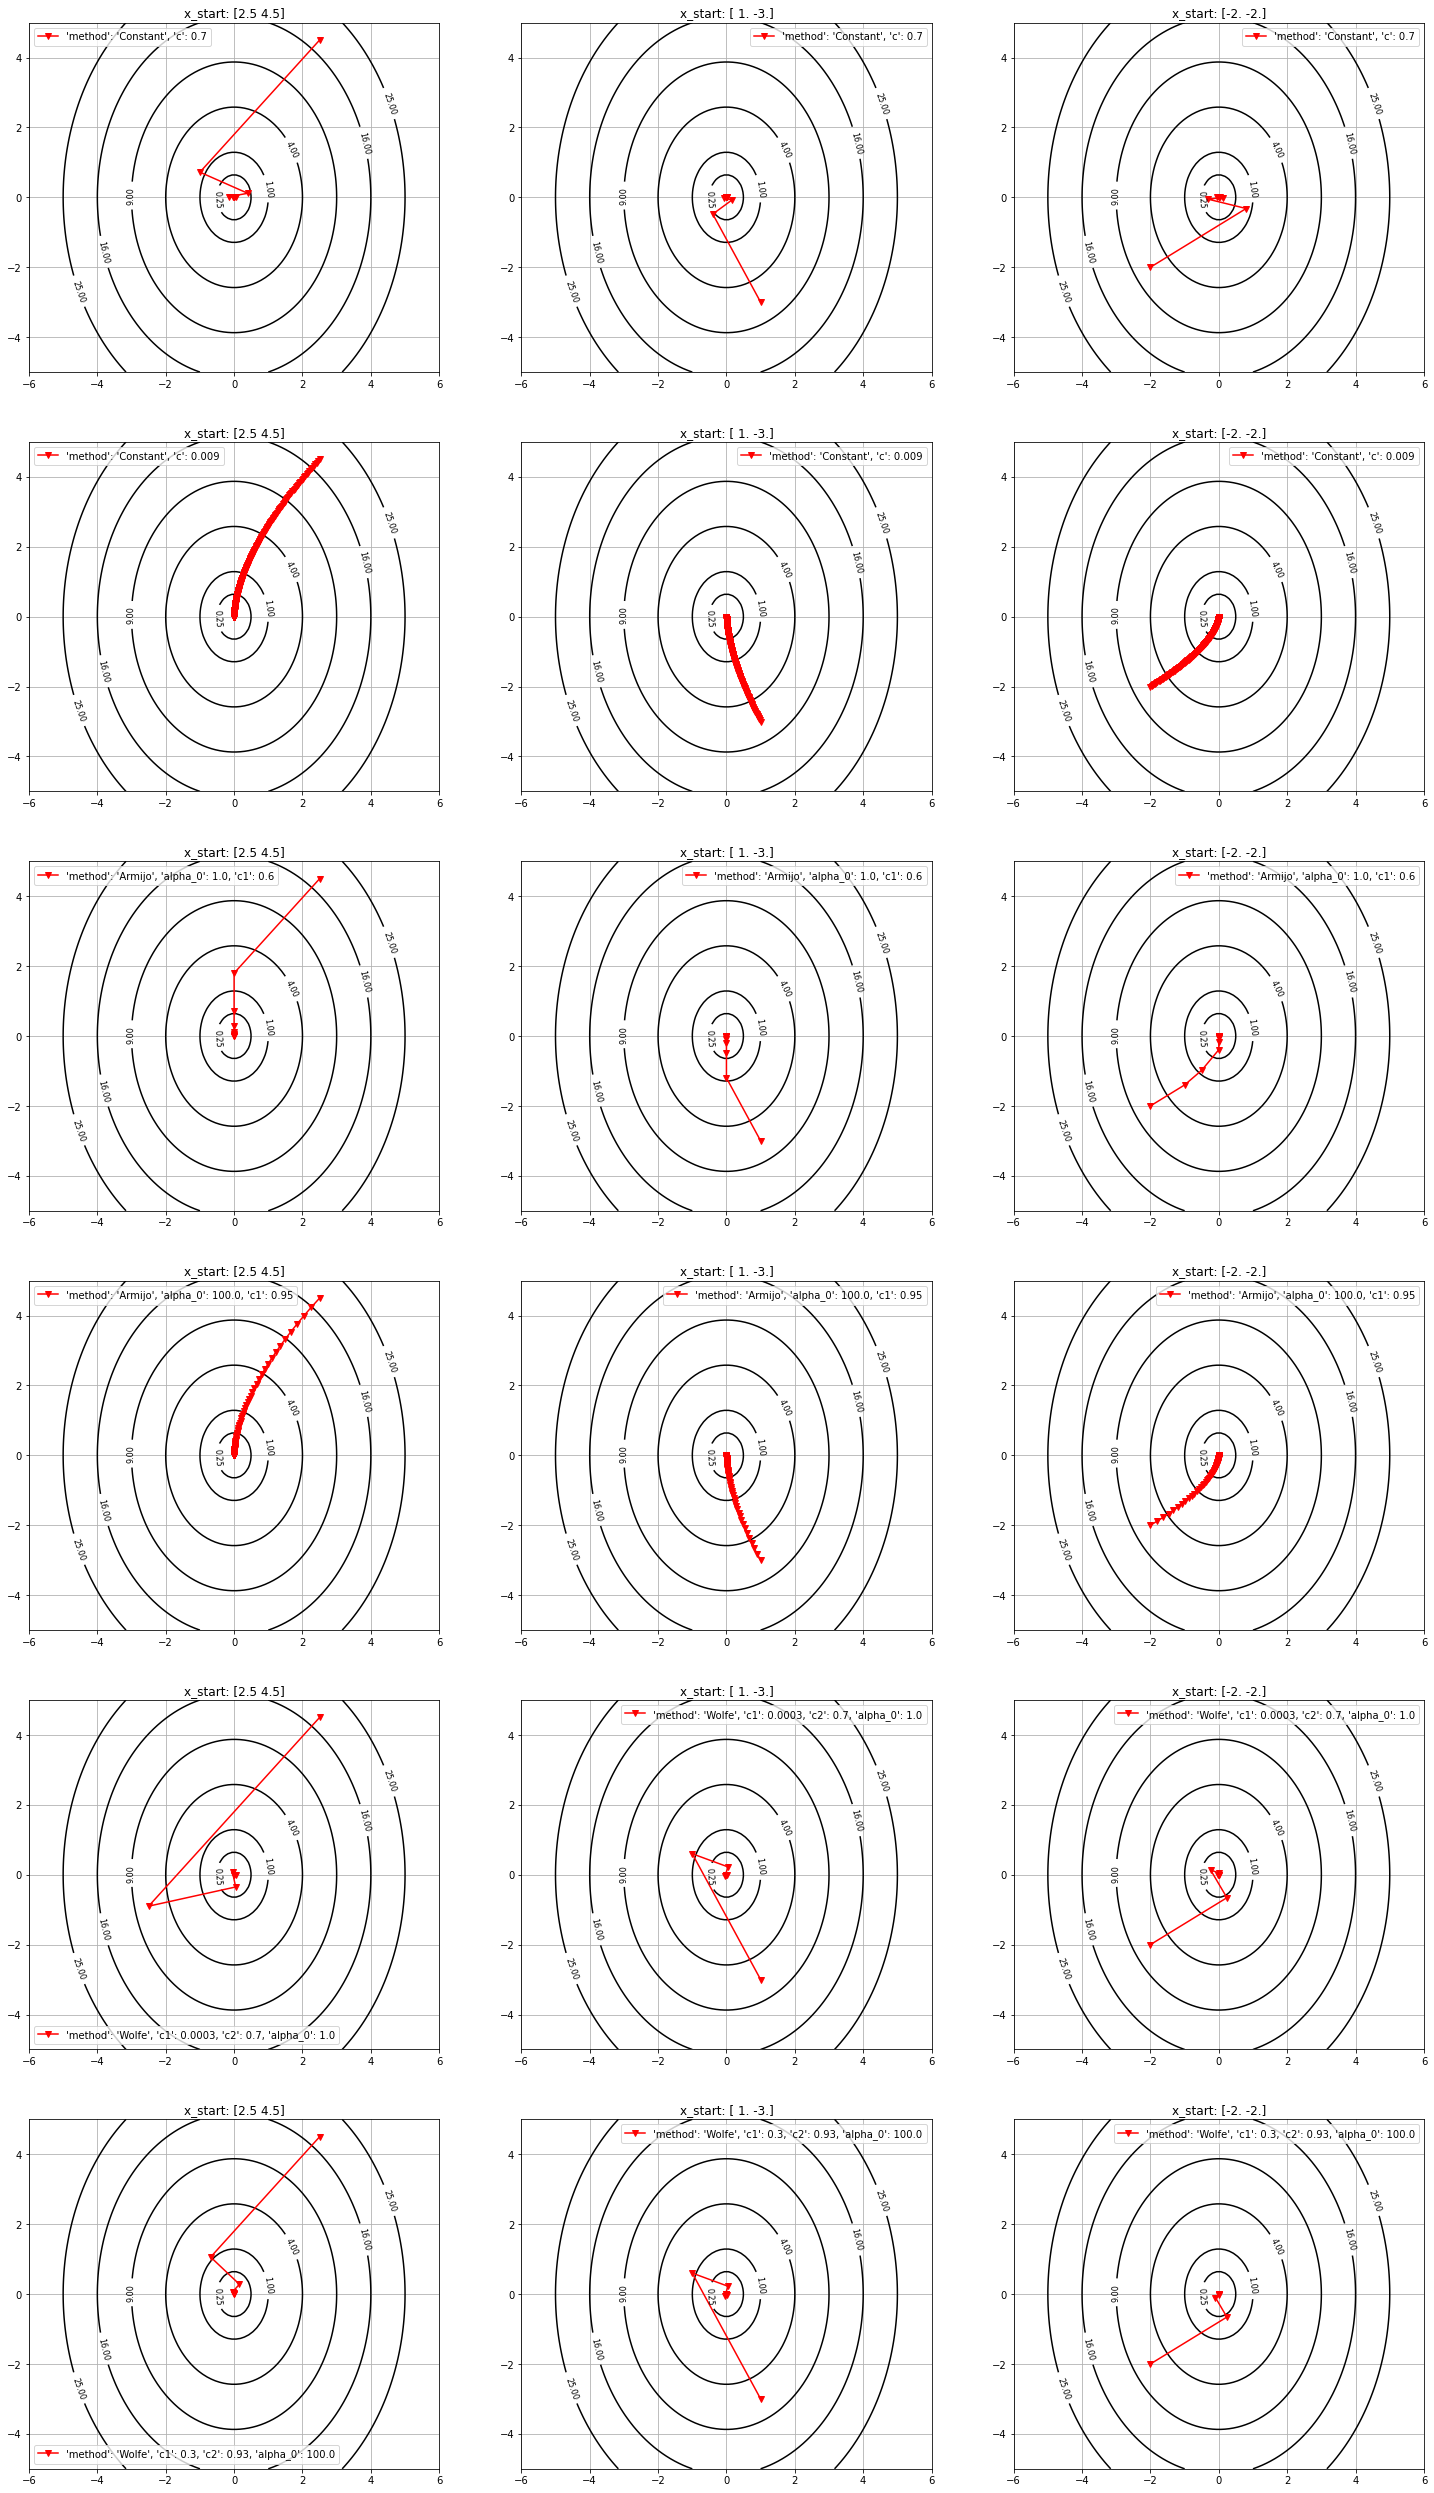

In [174]:
fig, ax = plt.subplots(len(methods), len(x_start), figsize = (25,45))
for i in range(len(methods)):
    for j in range(len(x_start)):
        [x_s, msg, history] = optimization.gradient_descent(oracle, x_start[j], line_search_options = methods[i], trace=True)
        plot_levels(oracle.func, ax[i][j])
        plot_trajectory(oracle.func, history['x'], ax[i][j], label=str(methods[i])[1:-1])
        ax[i][j].set_title("x_start: " + str(x_start[j]))
        ax[i][j].legend()

## Плохо обусловленная матрица

In [186]:
A = np.array([[1, 1.05],[1.05, 2.003]])
b = np.array([2, 2.3])
oracle = oracles.QuadraticOracle(A, b)
print('Число обусловленности:', np.linalg.norm(A) * np.linalg.norm(np.linalg.inv(A)))

Число обусловленности: 8.014446418656304


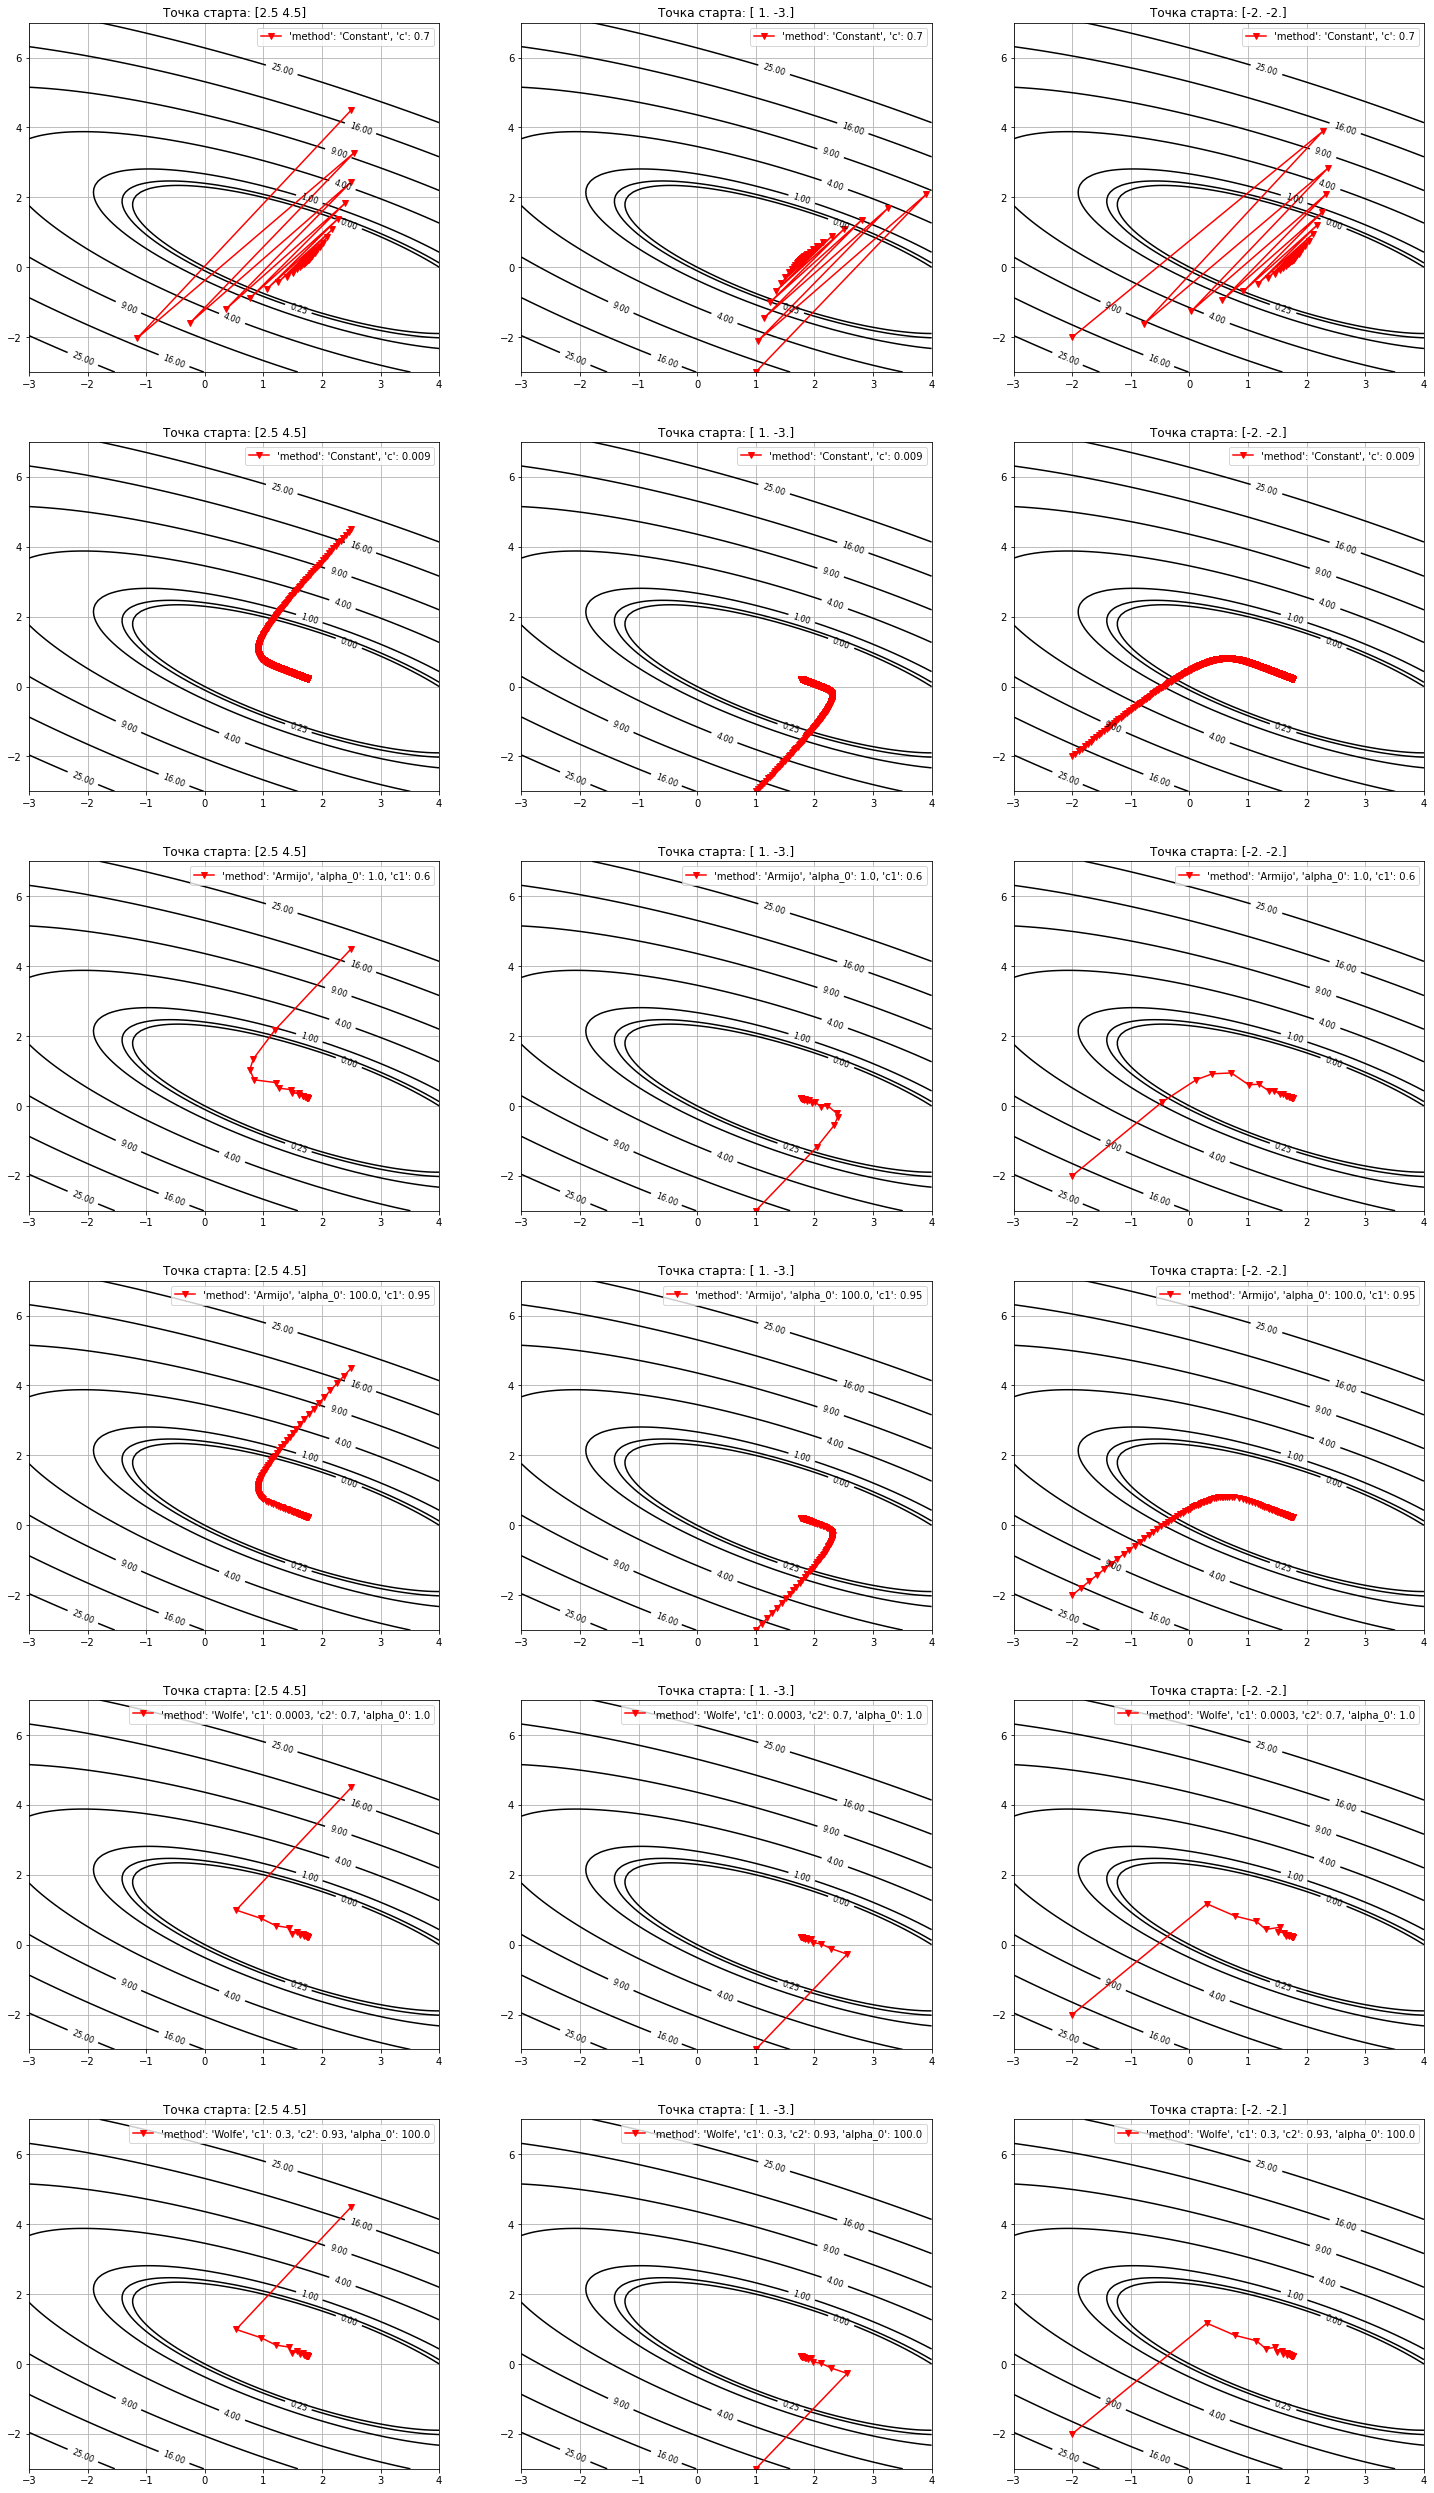

In [187]:
fig, ax = plt.subplots(len(methods), len(x_start), figsize = (25,45))
for i in range(len(methods)):
    for j in range(len(x_start)):
        [_, _, history] = optimization.gradient_descent(oracle, x_start[j], line_search_options = methods[i], trace=True)
        plot_levels(oracle.func, ax[i][j], xrange=[-3,4], yrange=[-3,7])
        plot_trajectory(oracle.func, history['x'], ax[i][j], label=str(methods[i])[1:-1])
        ax[i][j].set_title("Точка старта: " + str(x_start[j]))
        ax[i][j].legend()

**Ответ:** Стабильнее всего себя показал метод Вульфа.

# Зависимость числа итераций градиентного спуска от числа обусловленности и размерности пространства

Исследуйте, как зависит число итераций, необходимое градиентному спуску для сходимости, от следующих двух параметров: 1) числа обусловленности κ ≥ 1 оптимизируемой функции и 2) размерности
пространства n оптимизируемых переменных.

In [188]:
k_range = np.arange(1, 101, 10)
options = [(10, 'r'), (100, 'g'), (1000, 'b')]
methods = [{'method': 'Constant', "c":0.01}, 
           {'method':'Armijo', 'alpha_0':1.0, 'c1':0.96}, 
           {"method":'Wolfe', 'c1':0.001, 'c2':0.7, 'alpha_0':1.0}]

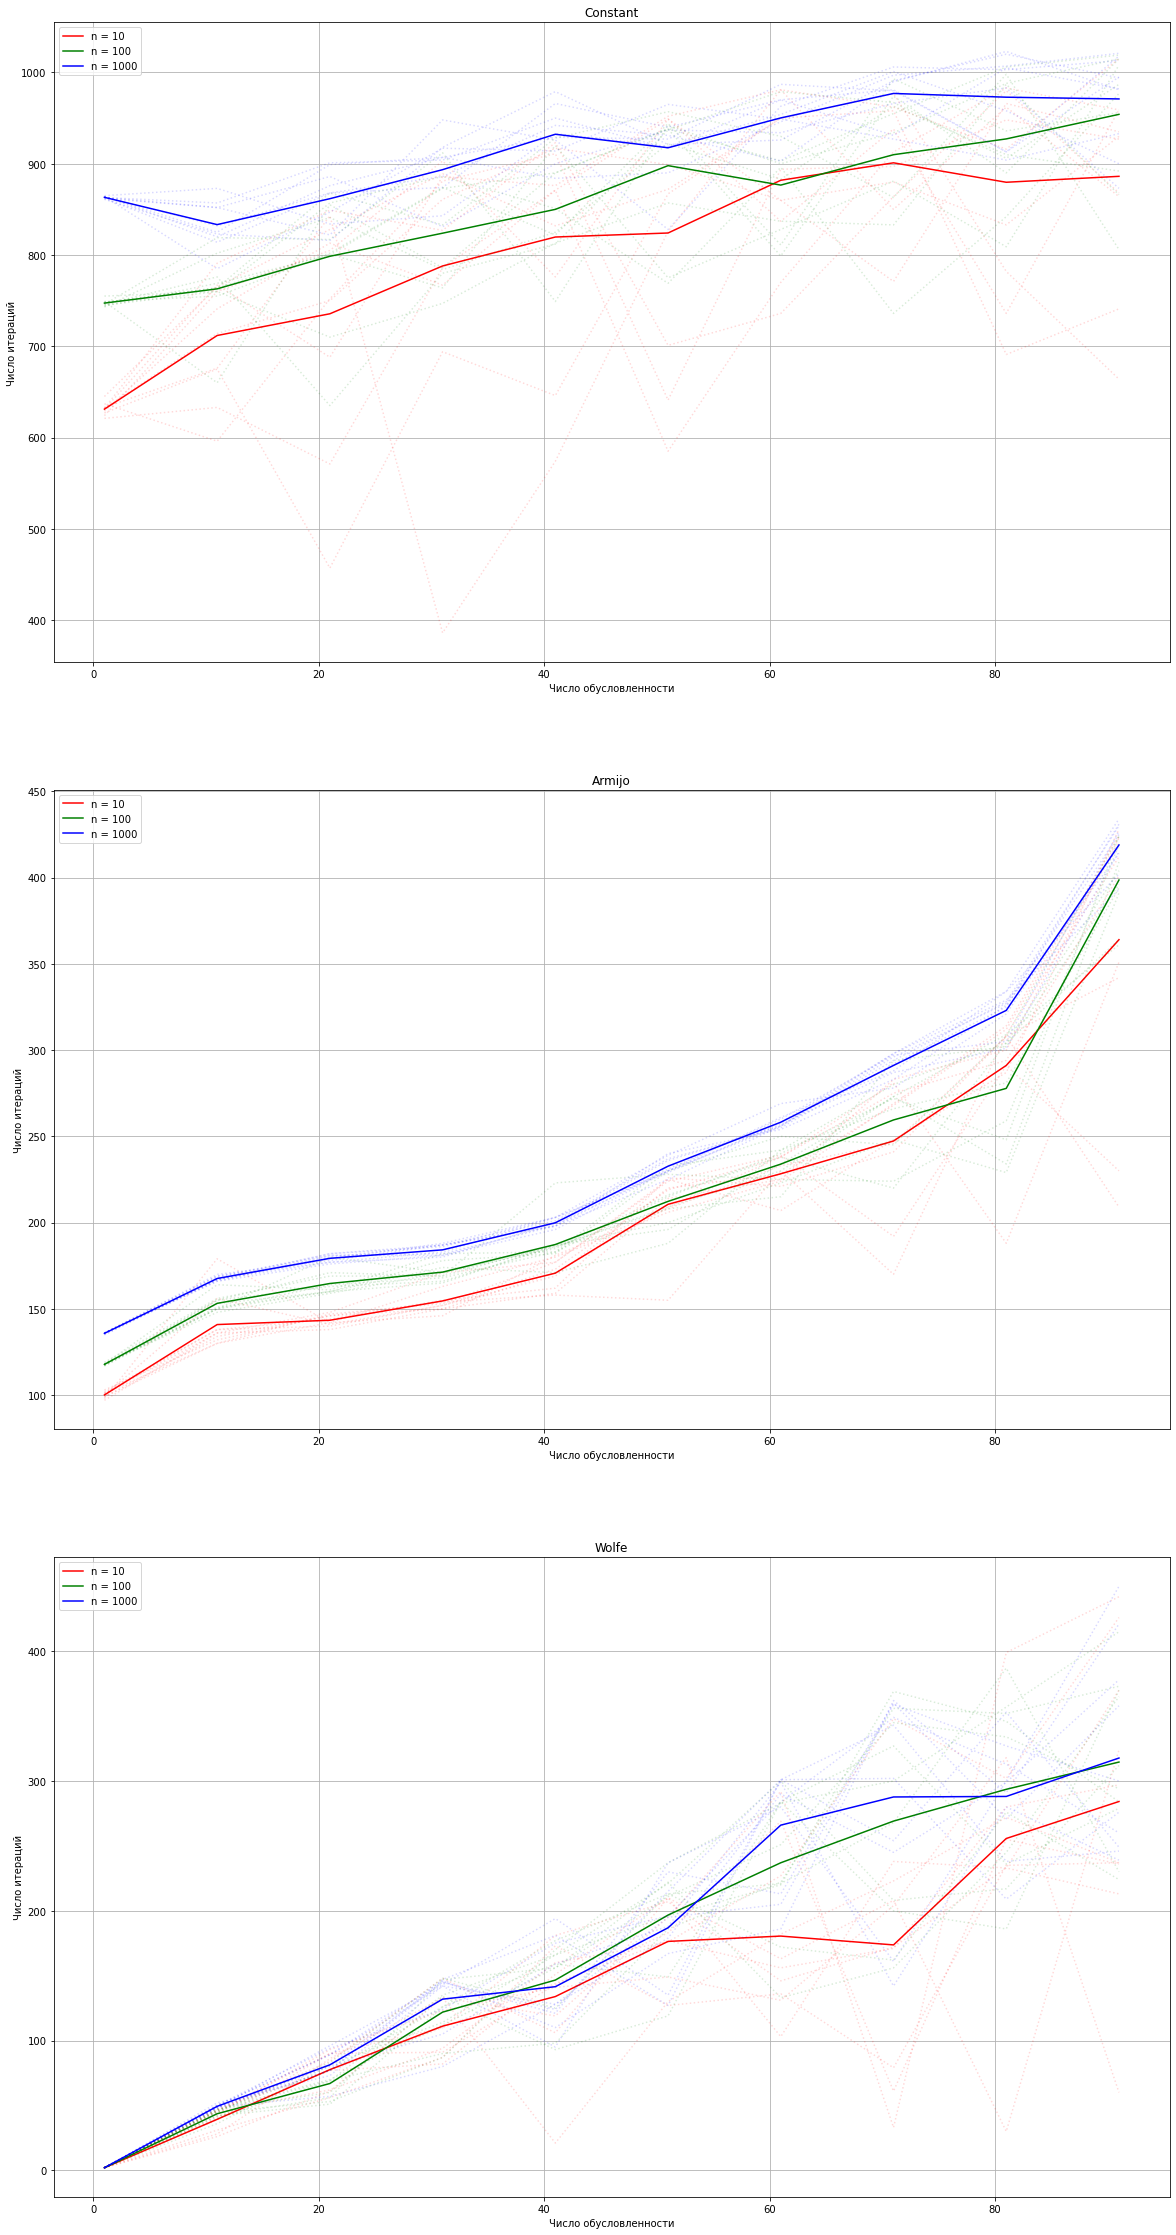

In [192]:
fig, ax = plt.subplots(3, 1, figsize=(20,40))

for i in range(len(methods)):
    for option in options:
        I = np.zeros(len(k_range))
        for j in range(10):
            s = []
            for k in k_range:
                d = np.random.uniform(1, k, option[0])
                d[0] = 1.; d[-1] = k
                A = scipy.sparse.diags(d)
                b = np.random.rand(option[0])*k
                oracle = oracles.QuadraticOracle(A, b)
                _, _, history = optimization.gradient_descent(oracle, np.ones(option[0]), 
                                                              line_search_options = methods[i], trace=True)
                s.append(len(history['func']))
            I += np.array(s)
            ax[i].plot(k_range, s, color=option[1], linestyle=':', alpha=0.15)
        ax[i].plot(k_range, I/10, color=option[1], label=('n = '+str(option[0])))
        ax[i].legend()
        ax[i].set_xlabel("Число обусловленности")
        ax[i].set_ylabel("Число итераций")
        ax[i].set_title(methods[i]['method'])
        ax[i].grid()

**Вывод:** график зависимости роста числа итераций в зависимости от числа обусловленности не линеен, но близок к этому, в то время как зависимость от размерности наблюдается намного меньше.

# Сравнение методов градиентного спуска и Ньютона на реальной задаче логистической регрессии

Сравнить методы градиентного спуска и Ньютона на задаче обучения логистической регрессии на реальных данных.

В качестве реальных данных используйте следующие три набора с сайта LIBSVM3: w8a, gisette и real-sim. Коэффициент регуляризации взять стандартным образом: λ = 1=m.

Параметры обоих методов взять равными параметрам по умолчанию. Начальную точку выбрать x0 = 0.
Построить графики сходимости следующих двух видов:
- Зависимость значения функции от реального времени работы метода.
- Зависимость относительного квадрата нормы градиента $\vert\vert \nabla f(x_k) \vert\vert_2^2 / \vert\vert \nabla f(x_0) \vert\vert_2^2$ (в логарифмической шкале) против реального времени работы.

In [194]:
A1, b1 = load_svmlight_file('данные/w8a.txt')
A2, b2 = load_svmlight_file('данные/gisette_scale.bz2')
A3, b3 = load_svmlight_file('данные/real-sim.bz2')

In [195]:
data = [(A1, b1, "w8a"), (A2, b2, "gisette_scale"), (A3, b3, "real-sim")]

In [196]:
def methods_vs_time(it):
    coef_reg = 1 / len(it[1])
    oracle = oracles.create_log_reg_oracle(it[0], it[1], coef_reg)
    _, _, history_grad = optimization.gradient_descent(oracle, np.zeros(it[0].shape[1]), trace=True)
    _, _, history_newton = optimization.newton(oracle, np.zeros(it[0].shape[1]), trace=True)

    ax[0].plot(history_grad['time'], history_grad['func'], label="Метод градиентного спуска")
    ax[0].plot(history_newton['time'], history_newton['func'], label="Метод Ньютона")
    ax[0].set_xlabel('Время работы')
    ax[0].set_ylabel('Значение функции')
    ax[0].legend()
    ax[0].set_title(it[2])
    ax[0].grid()

    ax[1].plot(history_grad['time'], np.array(history_grad['grad_norm'])**2 / (history_grad['grad_norm'][0]**2), label="Метод градиентного спуска")
    ax[1].plot(history_newton['time'], np.array(history_newton['grad_norm'])**2 / (history_newton['grad_norm'][0]**2), label="Метод Ньютона")
    ax[1].set_yscale('log')
    ax[1].set_xlabel('Время работы')
    ax[1].set_ylabel(r'$\vert\vert \nabla f(x_k) \vert\vert_2^2 / \vert\vert \nabla f(x_0) \vert\vert_2^2$')
    ax[1].legend()
    ax[1].set_title(it[2])
    ax[1].grid()

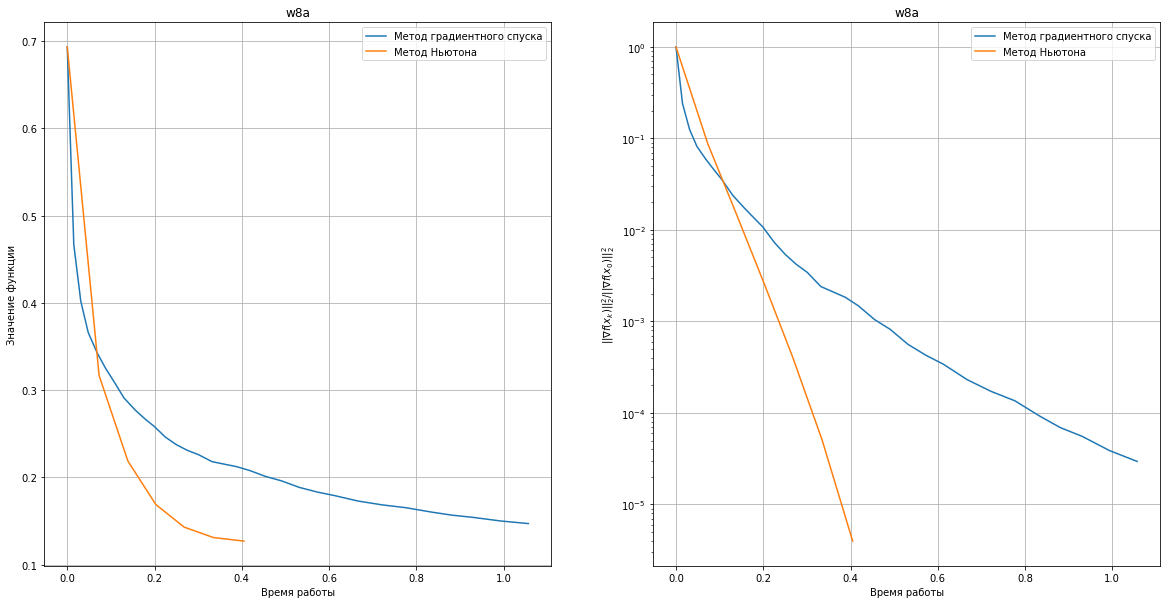

In [197]:
fig, ax = plt.subplots(1, 2, figsize=(20,10))
methods_vs_time(data[0])

**Вывод:** Как видно из графика, время работы метода градиентного спуска сильнее растёт вместе с заданной точностью (чем точнее, тем дольше).